In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# creating sqllite engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# Preparing the database
Base = automap_base()
Base.prepare(engine, reflect=True)

In [18]:
# Classes found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create session
session = Session(engine)

# EPA: Exploratory Precipitation Analysis

In [19]:
# Most recent date (.First())
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

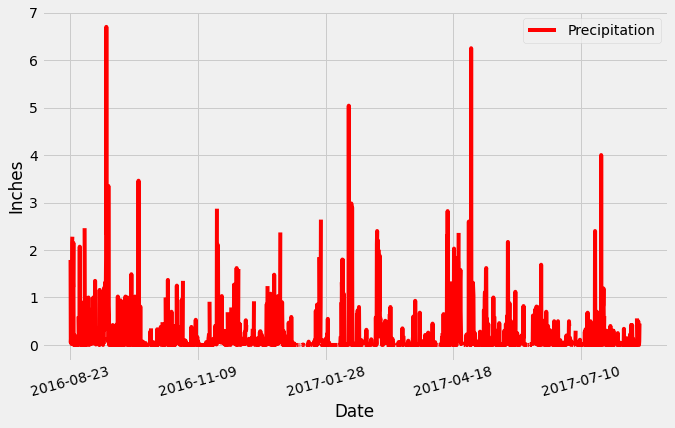

In [20]:
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Precipitation data retrieval
prcp_12m = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date)

# Create df with date index
df = pd.read_sql_query(prcp_12m.statement, engine, index_col='date')

# Sort by date
df_sort = df.sort_index(ascending=True, inplace=False)

# Plot with matplotlib
df_sort.plot(grid=True, xlabel='Date', ylabel='Inches', figsize=(10,6), rot=15, color='red')
plt.legend(['Precipitation'])

In [21]:
# Summary statistics
df_sort.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [22]:
# Count of the stations
session.query(Station).distinct().count()

9

In [23]:
# Stations by activity, Desc order.
stations = session.query(Measurement.station, 
                         func.count(Measurement.station)).\
                         order_by(func.count(Measurement.station).desc()).\
                         group_by(Measurement.station).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Lowest, highest, and average temperature of most active station.
active_station = stations[0][0]
    
lwst = session.query(func.min(Measurement.tobs)).\
                       filter_by(station = active_station).first()

hghst = session.query(func.max(Measurement.tobs)).\
                       filter_by(station = active_station).first()

avg = session.query(func.avg(Measurement.tobs)).\
                       filter_by(station = active_station).first()

print(f'{active_station} lowest temp is: {lwst[0]}')
print(f'{active_station} highest temp is: {hghst[0]}')
print(f'{active_station} average temp is: {avg[0]}')

USC00519281 lowest temp is: 54.0
USC00519281 highest temp is: 85.0
USC00519281 average temp is: 71.66378066378067


Text(0.5, 1.0, 'USC00519281: 1 year TOBS')

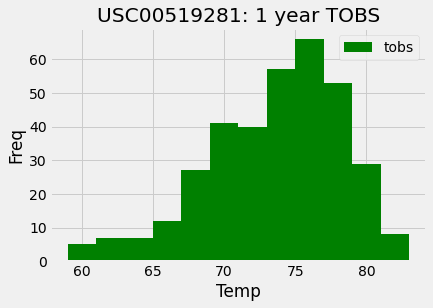

In [33]:
# Temp by Freq for the last 12 months of the most active station.
temp_12m = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.date >= query_date).\
            filter_by(station = active_station)

df_tobs = pd.read_sql_query(temp_12m.statement, engine, index_col='date')
df_tobs.hist(grid=True, figsize=(6,4), bins=12, color="green")
plt.legend(['tobs'])
plt.xlabel('Temp')
plt.ylabel('Freq')
plt.title(f'{active_station}: 1 year TOBS')

# Close session

In [35]:
# Close Session
session.close()